# Imports

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB # naive bayes
from sklearn import svm # support vector machines
from sklearn import linear_model # logistic regression
from sklearn import preprocessing
import xgboost as xgb # xgboost
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import optuna

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [3]:
df = pd.read_csv(r"C:\Users\casey\OneDrive\Documents\Data_Science\pandas_exercises\data\Unclean_Data_Titanic-7.csv", sep=',')
df.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

# EDA

* Look for relvant columns
* Explore columns for missing values, values that don't make sense

Get rows and columns

In [4]:
print('There are ', df.shape[0], ' rows.')
print('There are ', df.shape[1], ' columns.')
print('Column Names: ', df.columns)
print('Column Types: ', df.dtypes)

There are  891  rows.
There are  15  columns.
Column Names:  Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')
Column Types:  survived         int64
pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
embarked        object
class           object
who             object
adult_male        bool
deck            object
embark_town     object
alive           object
alone             bool
dtype: object


Check for any missing values in relevant columns

In [5]:
## CHECK FOR MISSING VALUES
# age, embarked, embarked_town, deck have missing values, will have to deal with them
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


Check relevant columns for values that don't make sense

In [22]:
df.age.sort_values().unique()

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ,   nan])

In [23]:
df.fare.sort_values().unique()

array([  0.    ,   4.0125,   5.    ,   6.2375,   6.4375,   6.45  ,
         6.4958,   6.75  ,   6.8583,   6.95  ,   6.975 ,   7.0458,
         7.05  ,   7.0542,   7.125 ,   7.1417,   7.225 ,   7.2292,
         7.25  ,   7.3125,   7.4958,   7.5208,   7.55  ,   7.6292,
         7.65  ,   7.725 ,   7.7292,   7.7333,   7.7375,   7.7417,
         7.75  ,   7.775 ,   7.7875,   7.7958,   7.8   ,   7.8292,
         7.8542,   7.875 ,   7.8792,   7.8875,   7.8958,   7.925 ,
         8.0292,   8.05  ,   8.1125,   8.1375,   8.1583,   8.3   ,
         8.3625,   8.4042,   8.4333,   8.4583,   8.5167,   8.6542,
         8.6625,   8.6833,   8.7125,   8.85  ,   9.    ,   9.2167,
         9.225 ,   9.35  ,   9.475 ,   9.4833,   9.5   ,   9.5875,
         9.825 ,   9.8375,   9.8417,   9.8458,  10.1708,  10.4625,
        10.5   ,  10.5167,  11.1333,  11.2417,  11.5   ,  12.    ,
        12.275 ,  12.2875,  12.35  ,  12.475 ,  12.525 ,  12.65  ,
        12.875 ,  13.    ,  13.4167,  13.5   ,  13.7917,  13.8

In [21]:
print(df.survived.value_counts())
print(df.pclass.value_counts())
print(df.sibsp.value_counts())
print(df.parch.value_counts())

survived
0    549
1    342
Name: count, dtype: int64
pclass
3    491
1    216
2    184
Name: count, dtype: int64
sibsp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64


* embarked and embarked_town are the same, remove one
* survived and alive are the same, remove one

In [15]:
print(df.alive.value_counts())
print(df.alone.value_counts())
print(df.deck.value_counts())
print(df.embark_town.value_counts())
print(df.adult_male.value_counts())
print(df.who.value_counts())
print(df['class'].value_counts())
print(df.embarked.value_counts())
print(df.sex.value_counts())

alive
no     549
yes    342
Name: count, dtype: int64
alone
True     537
False    354
Name: count, dtype: int64
deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64
embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64
adult_male
True     537
False    354
Name: count, dtype: int64
who
man      537
woman    271
child     83
Name: count, dtype: int64
class
Third     491
First     216
Second    184
Name: count, dtype: int64
embarked
S    644
C    168
Q     77
Name: count, dtype: int64
sex
male      577
female    314
Name: count, dtype: int64


## Label Balance
### If Imbalanced
* Random Undersampling
* Use tree based methods
* Anomaly Detection if only two classes
* Class weights

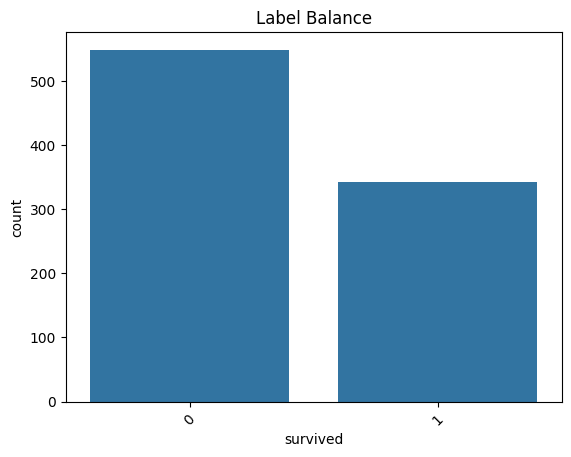

In [17]:
sns.countplot(data=df, x='survived')
# plt.ylim(0, 26000)
# plt.text(0.65, 13000, str(positive_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(2.7, 11500, str(negative_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(3.7, 9000, str(neutral_percent) + '%', size='medium', color='black', weight='semibold')
plt.title('Label Balance')
plt.xticks(rotation=45)
plt.show()

In [18]:
# Label percentages
label_counts = df['survived'].value_counts()
label_percentages = (label_counts / len(df)) * 100

# Print label counts and percentages
print("Label Counts:")
print(label_counts)
print("\nLabel Percentages (%):")
print(label_percentages)

Label Counts:
survived
0    549
1    342
Name: count, dtype: int64

Label Percentages (%):
survived
0    61.616162
1    38.383838
Name: count, dtype: float64


# Pre-Processing

* Encode labels if necessary
* Remove embark_town since it's the same as embarked, alive since it's the same as survived, class since it's the same as pclass, deck since >50% of values missing
* Fill missing values in embarked, mode imputation
* Fill missing values in age, mean imputation after grouping by who (man, woman, child)
* One Hot Encoding: pclass, sex, embarked, alone, adult_male, who
* Train test split
* Random Undersampling if necessary
* Scale data (fit_transform on train, transform on test)

Label Encoding if Necessary

In [ ]:
# label_mapping_int = {
#     "Exited_Yes": 1,
#     "Exited_No": 0,
# }

# df['Exited'] = df['Exited'].map(label_mapping_int).fillna(df['Exited'])

# print('\nAfter Mapping')
# print(df.info())
# print(df.Exited.value_counts())

Remove Columns

In [4]:
X = df.drop(columns=['embark_town', 'alive', 'deck', 'class', 'survived'], axis=1) # remove unnecessary cols and label col
y = df['survived']

Deal with missing values

In [5]:
# embarked has 2 missing values
# will replace with the mode since categorical
mode = X.embarked.mode()
print(mode)
X['embarked'] = X['embarked'].fillna(mode[0])

0    S
Name: embarked, dtype: object


In [6]:
# age may have a relationship with other columns, so try imputing after grouping
#df.age.fillna(df.age.median(), inplace = True)
X['age'] = X.groupby([X['pclass'], X['who']])['age'].apply(lambda x: x.fillna(x.mean())).reset_index(level=[0,1], drop=True)

Check missing values are dealt with

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      891 non-null    int64  
 1   sex         891 non-null    object 
 2   age         891 non-null    float64
 3   sibsp       891 non-null    int64  
 4   parch       891 non-null    int64  
 5   fare        891 non-null    float64
 6   embarked    891 non-null    object 
 7   who         891 non-null    object 
 8   adult_male  891 non-null    bool   
 9   alone       891 non-null    bool   
dtypes: bool(2), float64(2), int64(3), object(3)
memory usage: 57.6+ KB


One-hot encoding

In [8]:
X_encoded = pd.get_dummies(X, columns=['pclass', 'sex', 'embarked', 'alone', 'adult_male', 'who'], dtype=int)
X_encoded.head()

age  sibsp  parch     fare  pclass_1  pclass_2  pclass_3  sex_female  \
0  22.0      1      0   7.2500         0         0         1           0   
1  38.0      1      0  71.2833         1         0         0           1   
2  26.0      0      0   7.9250         0         0         1           1   
3  35.0      1      0  53.1000         1         0         0           1   
4  35.0      0      0   8.0500         0         0         1           0   

   sex_male  embarked_C  embarked_Q  embarked_S  alone_False  alone_True  \
0         1           0           0           1            1           0   
1         0           1           0           0            1           0   
2         0           0           0           1            0           1   
3         0           0           0           1            1           0   
4         1           0           0           1            0           1   

   adult_male_False  adult_male_True  who_child  who_man  who_woman  
0                 0                1          0        1          0  
1                 1                0          0        0          1  
2                 1                0          0        0          1  
3                 1                0          0        0          1  
4                 0                1          0        1          0

Train_test_split
* Since there is label imbalance ensure stratify is used

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y)

In [17]:
# Print percentage of each label in the training set
train_label_counts = np.bincount(y_train)
train_label_percentages = train_label_counts / len(y_train) * 100

print("Training Set Label Percentages:")
for label, percentage in enumerate(train_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

# Print percentage of each label in the testing set
test_label_counts = np.bincount(y_test)
test_label_percentages = test_label_counts / len(y_test) * 100

print("\nTesting Set Label Percentages:")
for label, percentage in enumerate(test_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

Training Set Label Percentages:
Label 0: 61.66%
Label 1: 38.34%

Testing Set Label Percentages:
Label 0: 61.45%
Label 1: 38.55%


Random Undersampling if necessary

In [87]:
train_df = X_train.copy()
train_df['train_labels'] = y_train

X = train_df.drop(columns=['train_labels'], axis=1) # Features
y = train_df['train_labels']  # Target/Labels

# Before undersampling
print('Original dataset class distribution:', Counter(y))

# Create the RandomUnderSampler object
rus = RandomUnderSampler(random_state=42) # can specify ratio you want as well

# Perform undersampling
X_res, y_res = rus.fit_resample(X, y)

# After undersampling
print('Resampled dataset class distribution:', Counter(y_res))
# Print percentage of each label in the testing set
test_label_counts = np.bincount(y_test)
test_label_percentages = test_label_counts / len(y_test) * 100

print("\nTesting Set Label Percentages:")
for label, percentage in enumerate(test_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

# Convert the resampled dataset back to DataFrame if needed
train_df_resampled = pd.DataFrame(X_res, columns=X.columns)
train_df_resampled['train_labels'] = y_res
print(train_df_resampled)

X_train_res = train_df_resampled.drop(columns=['train_labels'], axis=1) # Features
y_train_res = train_df_resampled['train_labels']

Original dataset class distribution: Counter({0: 439, 1: 273})
Resampled dataset class distribution: Counter({0: 273, 1: 273})

Testing Set Label Percentages:
Label 0: 61.45%
Label 1: 38.55%
           age  sibsp  parch     fare  pclass_1  pclass_2  pclass_3  \
175  18.000000      1      1   7.8542         0         0         1   
699  42.000000      0      0   7.6500         0         0         1   
824   2.000000      4      1  39.6875         0         0         1   
277  33.588889      0      0   0.0000         0         1         0   
313  28.000000      0      0   7.8958         0         0         1   
..         ...    ...    ...      ...       ...       ...       ...   
125  12.000000      1      0  11.2417         0         0         1   
330  27.854167      2      0  23.2500         0         0         1   
310  24.000000      0      0  83.1583         1         0         0   
437  24.000000      2      3  18.7500         0         1         0   
710  24.000000      0      0

Scaling if necessary

In [11]:
scaler = MinMaxScaler((0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

## XGBoost

### Baseline

In [16]:
clf = xgb.XGBClassifier(n_jobs=-1)

# Create the pipeline and train on the full training data
model = make_pipeline(clf)
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred_test = model.predict(X_test)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_test, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Survived": 0,
    "Not Survived": 1,
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

# Print classification report
report = classification_report(y_true=y_test, y_pred=y_pred_test, target_names=target_names)
print(report)

Validation Macro F1 Score: 0.7787
              precision    recall  f1-score   support

    Survived       0.82      0.85      0.84       110
Not Survived       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



Evaluating on training set to check if overfitting initially

In [92]:
# Evaluate on training set to see if overfitting
y_pred_train = model.predict(X_train)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_train, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")


# Get label names instead of numbers in report
label_mapping_int = {
    "Survived": 0,
    "Not Survived": 1,
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

# Print classification report
report = classification_report(y_true=y_train, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.9731
              precision    recall  f1-score   support

    Survived       0.97      0.99      0.98       439
Not Survived       0.98      0.95      0.97       273

    accuracy                           0.97       712
   macro avg       0.98      0.97      0.97       712
weighted avg       0.97      0.97      0.97       712



Evaluate through cross val to also check potential overfitting on certain train/test split

In [94]:
clf = xgb.XGBClassifier(n_jobs=-1)

# Create the pipeline and train on the full training data
model = make_pipeline(clf)
model.fit(X_test, y_pred_test)

# Perform cross-validation
scores = cross_val_score(model, X_test, y_test, cv=5, n_jobs=-1, scoring='f1_macro') # scoring can be accuracy, f1_macro, precision_macro, recall_macro 
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.62469928 0.81939799 0.63879599 0.76623377 0.60227273]
0.6902799503414894


### Hyperparameter Tuning w Class Weights

Two Options
* Tune class weights for each class (probably gives better performance, but requires more trials to tune)
* Get class weights from inverse label proportion (smaller proportion labels get higher weights)

XGBoost can handle binary class weights as a parameter, otherwise have to add separately. This example is three class. Look up binary class weight syntax.

In [103]:
def objective_xgb(trial):
    # Hyperparameters for XGBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)  # Number of boosting rounds
    max_depth = trial.suggest_int('max_depth', 3, 30)  # Maximum depth of a tree
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  # Learning rate for shrinking the model
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # Subsample ratio of the training instance
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)  # Subsample ratio of columns when constructing each tree
    gamma = trial.suggest_float('gamma', 0, 5)  # Minimum loss reduction required to make a further partition on a leaf node

    ## Two Options for Class Weights
    # ## Option 1
    # # Tune class weights for class imbalance 
    class_weight_0 = trial.suggest_float('class_weight_0', 0.5, 4.0)  # Class weight for class 0
    class_weight_1 = trial.suggest_float('class_weight_1', 0.5, 4.0)  # Class weight for class 1
    class_weight_dict = {0: class_weight_0, 1: class_weight_1}

    # ## Option 2
    # # Calculate class weights based on proportions
    # unique_classes = np.unique(y_train)
    # class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
    # # Convert class weights to a dictionary for easy access
    # class_weight_dict = dict(zip(unique_classes, class_weights))

    # Create the XGBoost model with hyperparameters
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,  # Disable label encoding, to avoid warnings in newer versions
    )

    # Create a pipeline (XGBoost)
    model = make_pipeline(clf)

    # Calculate sample weights based on the class weights
    sample_weights = np.array([class_weight_dict[label] for label in y_train])

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='f1_macro', params={'xgbclassifier__sample_weight': sample_weights})  # Scoring can be accuracy, f1_macro, etc.
    accuracy = scores.mean()

    return accuracy

In [104]:
# Create Optuna study
study_xgb = optuna.create_study(direction='maximize')

[I 2024-09-29 09:49:42,404] A new study created in memory with name: no-name-27287aa3-5bb2-40e8-b444-533e659b2741


In [107]:
# Optimize the study, trying 50 trials (you can increase this for better results)
study_xgb.optimize(objective_xgb, n_trials=10)

# Output the best hyperparameters
print('Best Trial: ', study_xgb.best_trial)
print("Best hyperparameters: ", study_xgb.best_params)

[I 2024-09-29 09:50:10,754] Trial 20 finished with value: 0.8269523015924689 and parameters: {'n_estimators': 52, 'max_depth': 11, 'learning_rate': 0.04704917654171924, 'subsample': 0.9148908956024873, 'colsample_bytree': 0.717744225658953, 'gamma': 2.408776563335927, 'class_weight_0': 3.5593589699805372, 'class_weight_1': 3.1681676960727976}. Best is trial 13 with value: 0.8284068393228547.
[I 2024-09-29 09:50:11,280] Trial 21 finished with value: 0.8164558937000039 and parameters: {'n_estimators': 91, 'max_depth': 30, 'learning_rate': 0.011849362328994001, 'subsample': 0.918709744343507, 'colsample_bytree': 0.7995440924831156, 'gamma': 2.3619907522730497, 'class_weight_0': 3.587150267505081, 'class_weight_1': 3.1022819149013747}. Best is trial 13 with value: 0.8284068393228547.
[I 2024-09-29 09:50:11,545] Trial 22 finished with value: 0.8284480277274537 and parameters: {'n_estimators': 57, 'max_depth': 10, 'learning_rate': 0.059349659720067255, 'subsample': 0.8713352643260274, 'colsa

Best Trial:  FrozenTrial(number=23, state=1, values=[0.8327166676548377], datetime_start=datetime.datetime(2024, 9, 29, 9, 50, 11, 546454), datetime_complete=datetime.datetime(2024, 9, 29, 9, 50, 11, 965301), params={'n_estimators': 52, 'max_depth': 10, 'learning_rate': 0.05244519075743002, 'subsample': 0.8504736739795865, 'colsample_bytree': 0.7028301369031354, 'gamma': 2.9311901621582743, 'class_weight_0': 2.9142958877015572, 'class_weight_1': 3.7161529827636652}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'max_depth': IntDistribution(high=30, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'class_weight_0': Float

Check Underfitting. If it is underfitting, adjust param space
* Increase max_depth
* Increase n_estimators
* Increase learning rate
* Increase subsample
* Increase colsample_bytree
* Decrease/Remove gamma
* Potentially decrease/remove alpha or lambda regularization
* Increase class weights
* Try Random Undersampling on minority class

In [108]:
# Best hyperparameters from Optuna study
best_params = study_xgb.best_params

clf = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    random_state=42,
    n_jobs=-1
)

## Option 1
# class_weight_dict = {0: best_params['class_weight_0'], 1: best_params['class_weight_1'], 2: best_params['class_weight_2']}

## Option 2
# Calculate class weights based on proportions
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
# Convert class weights to a dictionary for easy access
class_weight_dict = dict(zip(unique_classes, class_weights))

sample_weights = np.array([class_weight_dict[label] for label in y_train])

# Create the pipeline and train on the full training data
model = make_pipeline(clf)
model.fit(X_train, y_train, xgbclassifier__sample_weight=sample_weights)

# Evaluate on validation set
y_pred_test = model.predict(X_test)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_test, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
report = classification_report(y_true=y_test, y_pred=y_pred_test)
print(report)

Validation Macro F1 Score: 0.7840
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



Check Overfitting. If it is overfitting, adjust param space
* Reduce max_depth
* Reduce n_estimators
* Reduce learning rate
* Reduce subsample
* Reduce colsample_bytree
* Increase gamma
* Potentially add alpha or lambda regularization
* Decrease class weights on overperforming classes

In [109]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(X_train)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_train, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")
report = classification_report(y_true=y_train, y_pred=y_pred_train)
print(report)

Train Macro F1 Score: 0.8508
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       439
           1       0.82      0.81      0.81       273

    accuracy                           0.86       712
   macro avg       0.85      0.85      0.85       712
weighted avg       0.86      0.86      0.86       712



[[95 15]
 [21 48]]


[Text(0, 0.5, '0: Survived'), Text(0, 1.5, '1: Not Survived')]

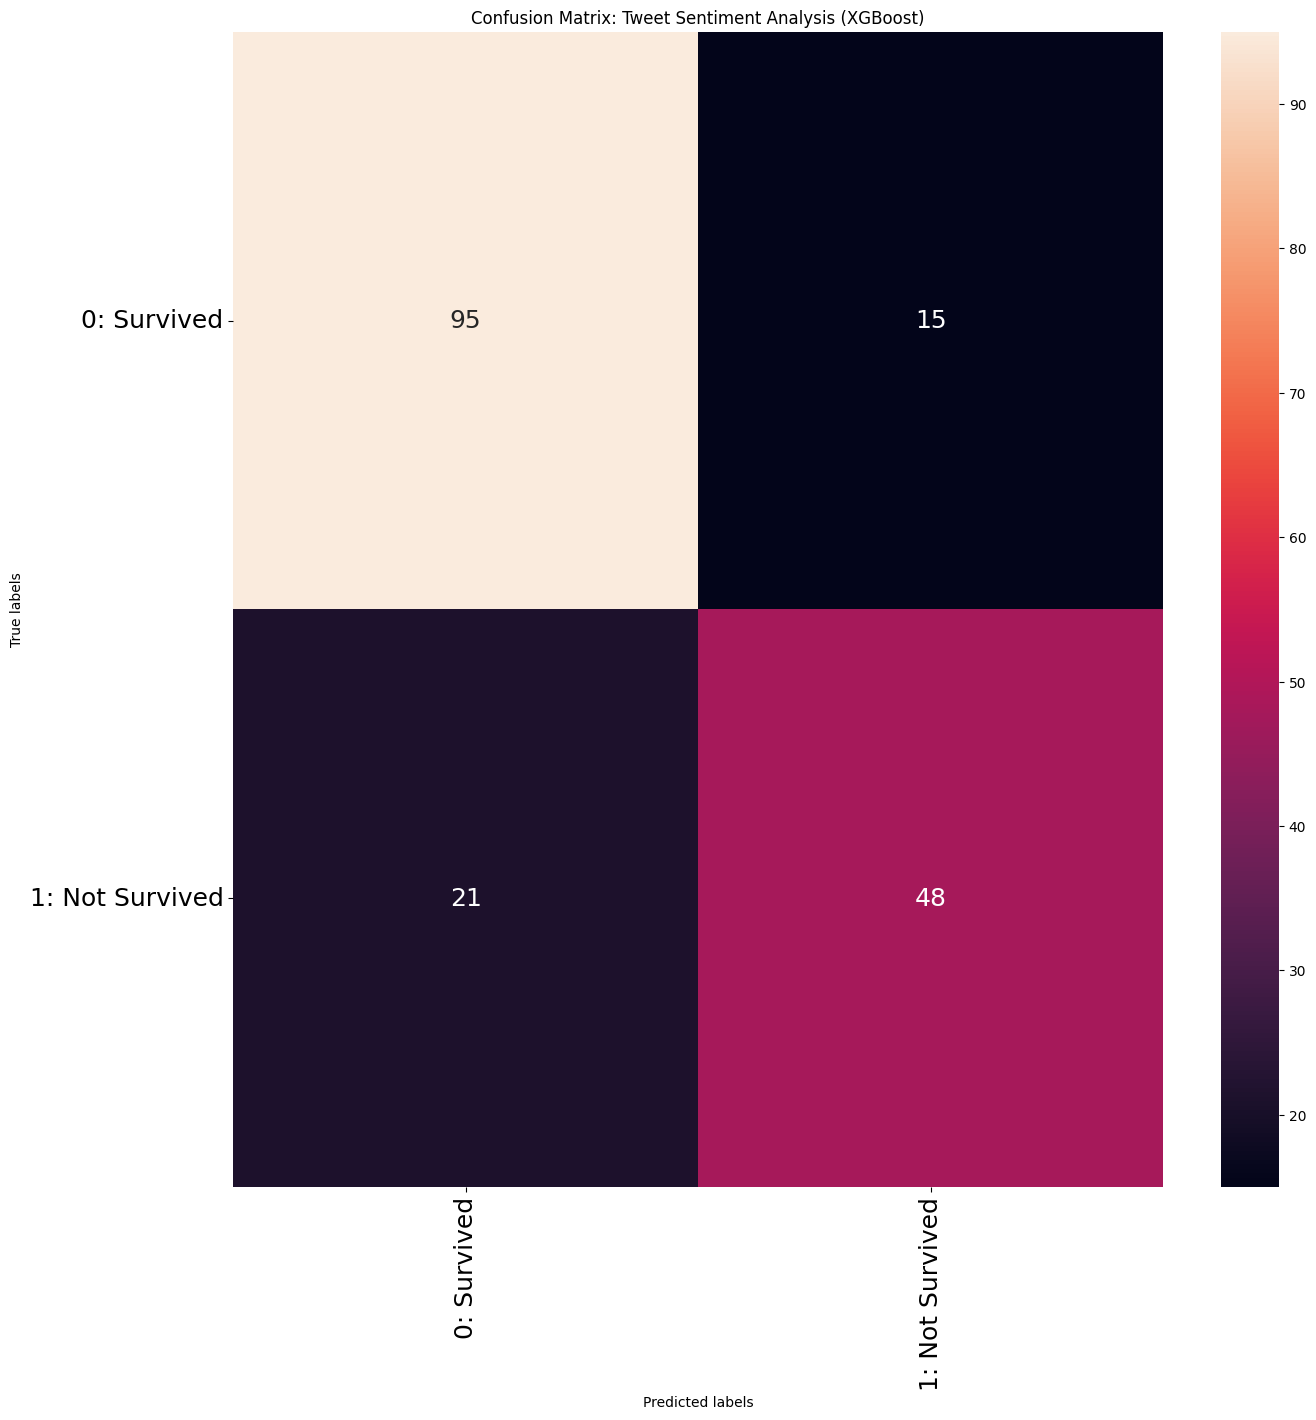

In [110]:
CM=confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (XGBoost)') 
ax.xaxis.set_ticklabels(["0: Survived","1: Not Survived"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Survived","1: Not Survived"],rotation=0, fontsize = 18)